**Emotion detection Model**



In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
data_zip = "/content/drive/MyDrive/4211_project/emotion_dataset_all.zip"

Mounted at /content/drive


In [ ]:
data_path = "new"
!unzip "$data_zip" > /dev/null 2>&1

**Imports**

In [ ]:
# Basic Libraries
import numpy as np
import tensorflow as tf
import csv
# Important submodules and functions from Tensorflow (and Keras)
from tensorflow.keras.layers import Input, Dense, Conv2D, UpSampling2D, Reshape, MaxPooling2D, Lambda, Layer, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.optimizers import Adam
# Image handling and visualization
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import cv2
import os
import sys
import json
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from tqdm import tqdm
from torch.utils.data import random_split
# Module settings:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # This will hide all TensorFlow messages, except for errors.
tf.get_logger().setLevel('ERROR')  # This sets TensorFlow logger to only output error messages.

**Helpful Functions**

In [ ]:
from PIL import Image,ImageEnhance
# resize the image
def resize_image(image, size):
    return image.resize(size)

# image crop
def crop_image(image, box):
    return image.crop(box)

def enhance_image(image, brightness_factor, contrast_factor):
    enhancer = ImageEnhance.Brightness(image)
    image_enhanced = enhancer.enhance(brightness_factor)
    enhancer = ImageEnhance.Contrast(image_enhanced)
    image_enhanced = enhancer.enhance(contrast_factor)
    return image_enhanced
# normalization
def normalize_image(image):
    image = np.array(image)
    image = image.astype('float32') / 255.0
    #print("normal",type(image))
    #numppy type return
    return image

# augment to create data diversity// pervent over fitting
def augment_image(image):
    # Random Horizontal Flip
    if np.random.random() < 0.5:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    # random rotate
    angle = np.random.randint(-15, 15)
    image = image.rotate(angle)
    #print("augment",type(image))
    # PIL type return
    return image

def convert_to_numpy(image):
    if isinstance(image,np.ndarray):
      return image
    else:
      np_array = np.array(image)
      return np_array

def load_image_dataset(image_path,target_size, normalize=True, augment=False, enhance=False, brightness_factor=1 , contrast_factor=1):
    images = []
    labels = []
    for path in image_path:
      image = Image.open(path)
      image = resize_image(image,target_size)
      #print(type(image))
      if augment:
          image = augment_image(image)
      if enhance:
          image = enhance_image(image,brightness_factor,contrast_factor)
      if normalize:
          image = normalize_image(image)
      image = convert_to_numpy(image)
      images.append(image)
      labels.append(path.split('/')[-2])  # Assume file path '/content/test/angry/im763.png'
    return images, labels
def find_images(dir_path, file_type):
    image_paths = []

    for root, _, files in os.walk(dir_path):
        for file in files:
            if f'.{file_type}' in file:
                image_paths.append(os.path.join(root, file))

    return image_paths

In [ ]:
import matplotlib.pyplot as plt

def show_images(images, labels):
    fig, axes = plt.subplots(nrows=len(images), ncols=1, figsize=(10, 10))

    for i, (image, label) in enumerate(zip(images, labels)):
        axes[i].imshow(image)
        axes[i].set_title(label)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


**Not use class DatasSet**


In [ ]:
class ImageDataset:
  def __init__(self,list_file_path,batch_size=8,random_seed=4221,image_resize=(256,256),normalize=True,augment=False,enhance=False,brightness_factor=1,contrast_factor=1):
    self.image_resize = image_resize
    self.batch_size = batch_size
    self.normalize = normalize
    self.augment = augment
    self.enhance = enhance
    self.brightness_factor = brightness_factor
    self.contrast_factor = contrast_factor
    self.random_state = np.random.RandomState(random_seed)
    self.list_of_file = []
    self.ds_pointer = 0
    self.list_of_file = list_file_path
    self.random_state.shuffle(self.list_of_file)
  def reset_pointer(self, seed=None):
      if seed != None:
        self.random_state = np.random.RandomState(seed)
      np.random.shuffle(self.list_of_file)
      self.ds_pointer = 0
  def __getitem__(self, index):
    batch_image = []
    if len(self.list_of_file) - self.ds_pointer < self.batch_size:
        self.ds_pointer = 0
        np.random.shuffle(self.list_of_file)

    path_img = self.list_of_file[self.ds_pointer:self.ds_pointer+self.batch_size]
    images, labels = load_image_dataset(path_img, self.image_resize, self.normalize, self.augment, self.enhance, self.brightness_factor, self.contrast_factor)
    images = np.array(images)
    print(np.shape(images))
    images = torch.from_numpy(images).permute(2, 0, 1).float()
    print(images.dim())
    self.ds_pointer += self.batch_size
    return images, labels

  def __len__(self):
      return len(self.list_of_file)

**Model Compoent**

In [ ]:
import torch.nn as nn
import torch

#18 and 34 layer residue
class BasicBlock(nn.Module):
    # expansion check if 卷积核有没有发生变化
    # downsample 用于虚线残差结构
    #in_chanel and out_chanel 输入输出矩阵的深度

    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                    kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                     kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample
    #正向传播的过程
    def forward(self, x):
        #捷径分支 identity
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    #RESNET 50，101 layers
    #第三卷积层是第一二卷积的4倍
    expansion = 4

    def __init__(self, in_channel, out_channel, stride=1, downsample=None,
                 groups=1, width_per_group=64):
        super(Bottleneck, self).__init__()

        width = int(out_channel * (width_per_group / 64.)) * groups

        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=width,
                               kernel_size=1, stride=1, bias=False)  # squeeze channels
        self.bn1 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv2 = nn.Conv2d(in_channels=width, out_channels=width, groups=groups,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv3 = nn.Conv2d(in_channels=width, out_channels=out_channel*self.expansion,
                               kernel_size=1, stride=1, bias=False)  # unsqueeze channels
        self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    #block 对应了上方的那个残缺模块
    #blokc_num 是一个list 对应resnet 的每层多少个block
    #num_class 训练集的分类个数

    def __init__(self,block,blocks_num,num_classes=7,include_top=True, groups=1,width_per_group=64):
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64

        self.groups = groups
        self.width_per_group = width_per_group

        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1  or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),nn.BatchNorm2d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel,channel,downsample=downsample,stride=stride,groups=self.groups,width_per_group=self.width_per_group))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel,
                                channel,
                                groups=self.groups,
                                width_per_group=self.width_per_group))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)

        return x


def resnet34(num_classes=7, include_top=True):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet50(num_classes=7, include_top=True):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet101(num_classes=7, include_top=True):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, include_top=include_top)


def resnext50_32x4d(num_classes=7, include_top=True):
    groups = 32
    width_per_group = 4
    return ResNet(Bottleneck, [3, 4, 6, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)


def resnext101_32x8d(num_classes=7, include_top=True):
    groups = 32
    width_per_group = 8
    return ResNet(Bottleneck, [3, 4, 23, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)

Random Select a Image to check label

71957


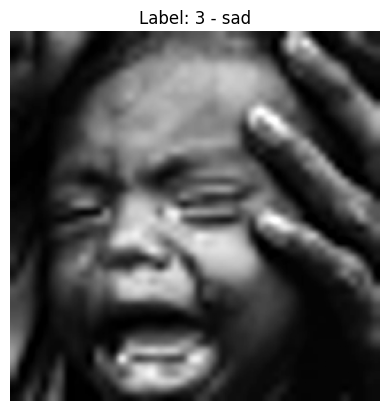

Label: 3
Label Name: sad


In [ ]:
import random
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import PIL

root = "/content/emotion_dataset_all/train"
transform = transforms.Compose([
    #transforms.CenterCrop((42, 42)),
        transforms.Resize(255, PIL.Image.BICUBIC),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Lambda(lambda img: ImageEnhance.Sharpness(img).enhance(0.5)),
        #transforms.Lambda(custom_function),
        transforms.Lambda(lambda img: enhance_image(img, 1, 1.3)),
        #transforms.RandomRotation(degrees=30),
        #transforms.ColorJitter(brightness=0.2, contrast=0.5, saturation=0.5),
        transforms.ToTensor(),
        #transforms.Normalize([0.46114907, 0.46114907, 0.46114907], [0.19896229, 0.19896229, 0.19896229]),
        #transforms.ToPILImage()
])


train_dataset = datasets.ImageFolder(root=root, transform=transform)
original_classes = train_dataset.classes
new_classes = ['neutral', 'happy', 'surprised', 'sad', 'angry', 'disgusted', 'fearful']
class_mapping = {new_classes[i]: i for i in range(len(original_classes))}

train_dataset.class_to_idx = class_mapping
print(len(train_dataset.samples))
for i in range(len(train_dataset.samples)):
    path, target = train_dataset.samples[i]
    new_target = class_mapping[train_dataset.classes[target]]
    train_dataset.samples[i] = (path, new_target)

train_dataset.classes = new_classes
# 随机选择一张图片
random_index = random.randint(0, len(train_dataset)-1)
image, label = train_dataset[random_index]
# 获取类别名称
class_names = train_dataset.classes
label_name = class_names[label]

# 显示图片和标签
import matplotlib.pyplot as plt

# 显示图片和标签
plt.imshow(image.permute(1, 2, 0))  # 将Tensor转换为NumPy数组并调整通道顺序
plt.title("Label: {} - {}".format(label, label_name))
plt.axis('off')
plt.show()
print("Label:", label)
print("Label Name:", label_name)

Experiments with different pre-processing of images

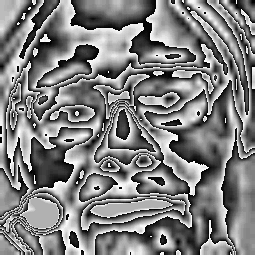

In [ ]:
from PIL import Image, ImageEnhance
from torchvision import transforms

temp = "/content/emotion_dataset_all/train/angry/im1.png"

img_pil = Image.open(temp, mode='r')
img_pil = img_pil.convert('RGB')

def custom_function(img):
    img = img.rotate(45)
    img = img.resize((100, 100))
    return img

def enhance_image(image, brightness_factor, contrast_factor):
    enhancer = ImageEnhance.Brightness(image)
    image_enhanced = enhancer.enhance(brightness_factor)
    enhancer = ImageEnhance.Contrast(image_enhanced)
    image_enhanced = enhancer.enhance(contrast_factor)
    return image_enhanced

transform = transforms.Compose([
    #transforms.CenterCrop((40, 40)),
    transforms.Resize(255),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Lambda(lambda img: ImageEnhance.Sharpness(img).enhance(0.2)),
    #transforms.Lambda(custom_function),
    transforms.Lambda(lambda img: enhance_image(img, 1, 1.2)),
    #transforms.RandomRotation(degrees=30),
    #transforms.ColorJitter(brightness=0.2, contrast=0.5, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.46114907, 0.46114907, 0.46114907], [0.19896229, 0.19896229, 0.19896229]),
    transforms.ToPILImage()
])

img_pil_normal = transform(img_pil)
img_pil_normal
#[0.46114907, 0.46114907, 0.46114907]
#[0.19896229, 0.19896229, 0.19896229]

Dataset loading

In [ ]:
# Image Processing in ImageFolder By transform
data_transform = {
    "train": transforms.Compose([
        #transforms.CenterCrop((42, 42)),
        transforms.Resize(255, PIL.Image.BICUBIC),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.Lambda(lambda img: ImageEnhance.Sharpness(img).enhance(0.5)),
        #transforms.Lambda(custom_function),
        transforms.Lambda(lambda img: enhance_image(img, 1, 1.2)),
        transforms.RandomRotation(degrees=30),
        #transforms.ColorJitter(brightness=0.2, contrast=0.5, saturation=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.46114907, 0.46114907, 0.46114907], [0.19896229, 0.19896229, 0.19896229]),
        #transforms.ToPILImage()

    ]),
    "val": transforms.Compose([
        #transforms.CenterCrop((42, 42)),
        transforms.Resize(255, PIL.Image.BICUBIC),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.Lambda(lambda img: ImageEnhance.Sharpness(img).enhance(0.5)),
        #transforms.Lambda(custom_function),
        transforms.Lambda(lambda img: enhance_image(img, 1, 1.2)),
        transforms.RandomRotation(degrees=30),
        #transforms.ColorJitter(brightness=0.2, contrast=0.5, saturation=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.46114907, 0.46114907, 0.46114907], [0.19896229, 0.19896229, 0.19896229]),
        #transforms.ToPILImage()
    ])
}

#load the train dataset
dataset = datasets.ImageFolder(root="/content/emotion_dataset_all/train", transform=data_transform["train"])
original_classes = dataset.classes
new_classes = ['neutral', 'happy', 'surprised', 'sad', 'angry', 'disgusted', 'fearful']
class_mapping = {new_classes[i]: i for i in range(len(original_classes))}
dataset.class_to_idx = class_mapping
targets = []
for i in range(len(dataset.samples)):
    path, target = dataset.samples[i]
    new_target = class_mapping[dataset.classes[target]]
    dataset.samples[i] = (path, new_target)
    targets.append(new_target)
dataset.classes = new_classes
emotional_list = dataset.class_to_idx
dataset.targets = targets
print(emotional_list)
print("The total len of dataset ",len(dataset))



{'neutral': 0, 'happy': 1, 'surprised': 2, 'sad': 3, 'angry': 4, 'disgusted': 5, 'fearful': 6}
The total len of dataset  71957


In [ ]:
#Check if GPU can use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

using cuda:0 device.


In [ ]:
cla_dict = dict((val, key) for key, val in emotional_list.items())
# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open('class_indices.json', 'w') as json_file:
    json_file.write(json_str)

Split the dataset into Train and Validate

In [ ]:
total_length = len(dataset)
train_length = int(0.8 * total_length)  # training set occupy 80%
val_length = total_length - train_length  #validation set occupy 20%
# random split
train_dataset, validate_dataset = random_split(dataset, [train_length, val_length])
train_num = len(train_dataset)
val_num = len(validate_dataset)
print("Using {} images for training, {} images for validation.".format(train_num,val_num))

Using 57565 images for training, 14392 images for validation.


Model compoent setting

In [ ]:
batch_size = 20
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True,num_workers=nw)
validate_loader = torch.utils.data.DataLoader(validate_dataset,batch_size=batch_size, shuffle=False,num_workers=nw)


Using 2 dataloader workers every process


In [ ]:
net = resnet101()
# load pretrain weights
model_weight_path_101 ="/content/drive/MyDrive/4211_project/resnet101-5d3b4d8f.pth"
#net.load_state_dict(torch.load(model_weight_path_101, map_location='cpu'))

# change fc layer structure
in_channel = net.fc.in_features
net.fc = nn.Linear(in_channel, 7)
net.to(device)

# define loss function
loss_function = nn.CrossEntropyLoss()

# construct an optimizer
params = [p for p in net.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.0001)

epochs = 5
best_acc = 0.0
save_path = './resNet50.pth'
train_steps = len(train_loader)
for epoch in range(epochs):
    # train
    net.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, file=sys.stdout)
    for step, data in enumerate(train_bar):
        images, labels = data
        optimizer.zero_grad()
        logits = net(images.to(device))
        loss = loss_function(logits, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,epochs,loss)

# validate
net.eval()
acc = 0.0  # accumulate accurate number / epoch
with torch.no_grad():
    val_bar = tqdm(validate_loader, file=sys.stdout)
    for val_data in val_bar:
        val_images, val_labels = val_data
        outputs = net(val_images.to(device))
        # loss = loss_function(outputs, test_labels)
        predict_y = torch.max(outputs, dim=1)[1]#只返回最大值的每个索引
        acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

        val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1,epochs)

val_accurate = acc / val_num
print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
      (epoch + 1, running_loss / train_steps, val_accurate))

if val_accurate > best_acc:
    best_acc = val_accurate
    torch.save(net.state_dict(), save_path)
    torch.save(net, 'full_model.pth')

print('Finished Training')


Use Test dataset to predict

In [ ]:
import torchvision.datasets as datasets
import torch.utils.data
from torchvision import transforms
# 加载测试集数据
test_dataset = datasets.ImageFolder(root="/content/emotion_dataset_all/test", transform=data_transform["val"])

original_classes = test_dataset.classes
new_classes = ['neutral', 'happy', 'surprised', 'sad', 'angry', 'disgusted', 'fearful']
class_mapping = {new_classes[i]: i for i in range(len(original_classes))}

test_dataset.class_to_idx = class_mapping
targets = []
for i in range(len(test_dataset.samples)):
    path, target = test_dataset.samples[i]
    new_target = class_mapping[test_dataset.classes[target]]
    test_dataset.samples[i] = (path, new_target)
    targets.append(new_target)
test_dataset.classes = new_classes
emotional_list = test_dataset.class_to_idx
test_dataset.targets = targets

print("The len of the testing set is ",len(test_dataset))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=nw)

# 加载已经训练好的模型
model = torch.load('/content/drive/MyDrive/4211_project/0.78/full_model.pth')
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images.to(device))
        predict_y = torch.max(outputs, dim=1)[1]
        total += labels.size(0)
        correct += (predict_y == labels.to(device)).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Single Image predict

In [ ]:
img = Image.open("/content/drive/MyDrive/4211_project/image/7.png")
img = img.convert("RGB")
transform = transforms.transforms.Compose([
        #transforms.CenterCrop((42, 42)),
        transforms.Resize(255, PIL.Image.BICUBIC),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Lambda(lambda img: ImageEnhance.Sharpness(img).enhance(0.5)),
        #transforms.Lambda(custom_function),
        #transforms.Lambda(lambda img: enhance_image(img, 1, 1.2)),
        #transforms.RandomRotation(degrees=30),
        transforms.ColorJitter(brightness=0.2, contrast=0.5, saturation=0.5),
        transforms.ToTensor(),
        #transforms.Normalize([0.46114907, 0.46114907, 0.46114907], [0.19896229, 0.19896229, 0.19896229]),
        #transforms.ToPILImage()
    ])
img = transform(img).unsqueeze(0)

# 使用模型进行预测
model = torch.load('/content/drive/MyDrive/4211_project/0.78/full_model.pth')
model.eval()
with torch.no_grad():
    output = model(img.to(device))
    _, predicted = torch.max(output.data, 1)

# 获取预测结果
class_names = dataset.classes
predicted_class = class_names[predicted.item()]
print("Predicted class:", predicted_class)

Predicted class: happy


**Keep Training**

In [ ]:

save_path = '/content/resNet50.pth'
net.load_state_dict(torch.load(save_path))
epochs = 1
best_acc = 0.0
save_path = '/content/resNet50.pth'
train_steps = len(train_loader)
for epoch in range(epochs):
    # train
    net.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, file=sys.stdout)
    for step, data in enumerate(train_bar):
        images, labels = data
        optimizer.zero_grad()
        logits = net(images.to(device))
        loss = loss_function(logits, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,epochs,loss)

# validate
net.eval()
acc = 0.0  # accumulate accurate number / epoch
with torch.no_grad():
    val_bar = tqdm(validate_loader, file=sys.stdout)
    for val_data in val_bar:
        val_images, val_labels = val_data
        outputs = net(val_images.to(device))
        # loss = loss_function(outputs, test_labels)
        predict_y = torch.max(outputs, dim=1)[1]#只返回最大值的每个索引
        acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

        val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1,epochs)

val_accurate = acc / val_num
print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
      (epoch + 1, running_loss / train_steps, val_accurate))

if val_accurate > best_acc:
    best_acc = val_accurate
    torch.save(net.state_dict(), save_path)
    torch.save(net, 'full_model.pth')

# 调用train()方法，继续训练
net.train()

print('Finished Training')


valid epoch[1/1]: 100%|██████████| 720/720 [01:55<00:00,  6.23it/s]
[epoch 1] train_loss: 0.492  val_accuracy: 0.787
Finished Training


**Load the trained model**

In [ ]:
import torch
model = torch.load('/content/drive/MyDrive/4211_project/0.78/full_model.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
!pip install onnx
!pip install onnxscript

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.8/594.8 kB 8.8 MB/s eta 0:00:00


In [ ]:
dummy_input = torch.randn(1, 3, 64, 64, device='cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!pip install onnx

In [ ]:
import onnx
torch.onnx.export(model,               # model being run
                  dummy_input,         # model input (or a tuple for multiple inputs)
                  "full_model.onnx",        # where to save the model (can be a file or file-like object)
                  export_params=True,  # store the trained parameter weights inside the model file
                  opset_version=11,    # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names=['input'],   # the model's input names
                  output_names=['output'], # the model's output names
                  dynamic_axes={'input': {0: 'batch_size'},  # variable length axes
                                'output': {0: 'batch_size'}})

# **Project Running-Real time emotion detection**

In [ ]:
import cv2
import numpy as np
import time
import os
from google.colab.patches import cv2_imshow

from cv2 import dnn
from math import ceil

image_mean = np.array([127, 127, 127])
image_std = 128.0
iou_threshold = 0.3
center_variance = 0.1
size_variance = 0.2
min_boxes = [
    [10.0, 16.0, 24.0],
    [32.0, 48.0],
    [64.0, 96.0],
    [128.0, 192.0, 256.0]
]
strides = [8.0, 16.0, 32.0, 64.0]
threshold = 0.5

def define_img_size(image_size):
    shrinkage_list = []
    feature_map_w_h_list = []
    for size in image_size:
        feature_map = [int(ceil(size / stride)) for stride in strides]
        feature_map_w_h_list.append(feature_map)

    for i in range(0, len(image_size)):
        shrinkage_list.append(strides)
    priors = generate_priors(
        feature_map_w_h_list, shrinkage_list, image_size, min_boxes
    )
    return priors


def generate_priors(
    feature_map_list, shrinkage_list, image_size, min_boxes
):
    priors = []
    for index in range(0, len(feature_map_list[0])):
        scale_w = image_size[0] / shrinkage_list[0][index]
        scale_h = image_size[1] / shrinkage_list[1][index]
        for j in range(0, feature_map_list[1][index]):
            for i in range(0, feature_map_list[0][index]):
                x_center = (i + 0.5) / scale_w
                y_center = (j + 0.5) / scale_h

                for min_box in min_boxes[index]:
                    w = min_box / image_size[0]
                    h = min_box / image_size[1]
                    priors.append([
                        x_center,
                        y_center,
                        w,
                        h
                    ])
    print("priors nums:{}".format(len(priors)))
    return np.clip(priors, 0.0, 1.0)


def hard_nms(box_scores, iou_threshold, top_k=-1, candidate_size=200):
    scores = box_scores[:, -1]
    boxes = box_scores[:, :-1]
    picked = []
    indexes = np.argsort(scores)
    indexes = indexes[-candidate_size:]
    while len(indexes) > 0:
        current = indexes[-1]
        picked.append(current)
        if 0 < top_k == len(picked) or len(indexes) == 1:
            break
        current_box = boxes[current, :]
        indexes = indexes[:-1]
        rest_boxes = boxes[indexes, :]
        iou = iou_of(
            rest_boxes,
            np.expand_dims(current_box, axis=0),
        )
        indexes = indexes[iou <= iou_threshold]
    return box_scores[picked, :]


def area_of(left_top, right_bottom):
    hw = np.clip(right_bottom - left_top, 0.0, None)
    return hw[..., 0] * hw[..., 1]


def iou_of(boxes0, boxes1, eps=1e-5):
    overlap_left_top = np.maximum(boxes0[..., :2], boxes1[..., :2])
    overlap_right_bottom = np.minimum(boxes0[..., 2:], boxes1[..., 2:])

    overlap_area = area_of(overlap_left_top, overlap_right_bottom)
    area0 = area_of(boxes0[..., :2], boxes0[..., 2:])
    area1 = area_of(boxes1[..., :2], boxes1[..., 2:])
    return overlap_area / (area0 + area1 - overlap_area + eps)


def predict(
    width,
    height,
    confidences,
    boxes,
    prob_threshold,
    iou_threshold=0.3,
    top_k=-1
):
    boxes = boxes[0]
    confidences = confidences[0]
    picked_box_probs = []
    picked_labels = []
    for class_index in range(1, confidences.shape[1]):
        probs = confidences[:, class_index]
        mask = probs > prob_threshold
        probs = probs[mask]
        if probs.shape[0] == 0:
            continue
        subset_boxes = boxes[mask, :]
        box_probs = np.concatenate(
            [subset_boxes, probs.reshape(-1, 1)], axis=1
        )
        box_probs = hard_nms(box_probs,
                             iou_threshold=iou_threshold,
                             top_k=top_k,
                             )
        picked_box_probs.append(box_probs)
        picked_labels.extend([class_index] * box_probs.shape[0])
    if not picked_box_probs:
        return np.array([]), np.array([]), np.array([])
    picked_box_probs = np.concatenate(picked_box_probs)
    picked_box_probs[:, 0] *= width
    picked_box_probs[:, 1] *= height
    picked_box_probs[:, 2] *= width
    picked_box_probs[:, 3] *= height
    return (
        picked_box_probs[:, :4].astype(np.int32),
        np.array(picked_labels),
        picked_box_probs[:, 4]
    )


def convert_locations_to_boxes(locations, priors, center_variance,
                               size_variance):
    if len(priors.shape) + 1 == len(locations.shape):
        priors = np.expand_dims(priors, 0)
    return np.concatenate([
        locations[..., :2] * center_variance * priors[..., 2:] + priors[..., :2],
        np.exp(locations[..., 2:] * size_variance) * priors[..., 2:]
    ], axis=len(locations.shape) - 1)


def center_form_to_corner_form(locations):
    return np.concatenate(
        [locations[..., :2] - locations[..., 2:] / 2,
         locations[..., :2] + locations[..., 2:] / 2],
        len(locations.shape) - 1
    )



def FER_live_cam():
    emotion_dict = {
        0: 'neutral',
        1: 'happiness',
        2: 'surprise',
        3: 'sadness',
        4: 'anger',
        5: 'disgust',
        6: 'fear'
    }

    cap = cv2.VideoCapture('/content/drive/MyDrive/4211_project/video3.mp4')
    # cap = cv2.VideoCapture(0)

    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    size = (frame_width, frame_height)
    result = cv2.VideoWriter('infer2-test.avi',
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         60, size)

    # Read Pytorch model
    model = torch.load('/content/drive/MyDrive/4211_project/0.78/full_model.pth', map_location=torch.device('cpu'))
    model.eval()

    #data transform
    data_transform = transforms.transforms.Compose([
        #transforms.CenterCrop((42, 42)),
        transforms.Resize(255, PIL.Image.BICUBIC),
        transforms.RandomHorizontalFlip(p=0.5),

        # 在旋转之前应用锐化操作
        transforms.Lambda(lambda img: ImageEnhance.Sharpness(img).enhance(0.5)),
        #transforms.Lambda(custom_function),
        #transforms.Lambda(lambda img: enhance_image(img, 1, 1.2)),
        #transforms.RandomRotation(degrees=30),
        transforms.ColorJitter(brightness=0.2, contrast=0.5, saturation=0.5),
        transforms.ToTensor(),
        #transforms.Normalize([0.46114907, 0.46114907, 0.46114907], [0.19896229, 0.19896229, 0.19896229]),
        #transforms.ToPILImage()
    ])
    #img = data_transform(img).unsqueeze(0)



    # Read the Caffe face detector.
    model_path = '/content/drive/MyDrive/4211_project/face_recogonition_model/RFB-320.caffemodel'
    proto_path = '/content/drive/MyDrive/4211_project/face_recogonition_model/RFB-320.prototxt'
    net = dnn.readNetFromCaffe(proto_path, model_path)
    input_size = [320, 240]
    width = input_size[0]
    height = input_size[1]
    priors = define_img_size(input_size)

    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            #frame_transformed = live_transform(frame_pil).unsqueeze(0)
            img_ori = frame
            print("frame size: ", frame.shape)
            rect = cv2.resize(img_ori, (width, height))
            rect = cv2.cvtColor(rect, cv2.COLOR_BGR2RGB)
            #frame_transformed = live_transform(rect).unsqueeze(0)
            net.setInput(dnn.blobFromImage(
                rect, 1 / image_std, (width, height), 127)
            )
            start_time = time.time()
            boxes, scores = net.forward(["boxes", "scores"])
            boxes = np.expand_dims(np.reshape(boxes, (-1, 4)), axis=0)
            scores = np.expand_dims(np.reshape(scores, (-1, 2)), axis=0)
            boxes = convert_locations_to_boxes(
                boxes, priors, center_variance, size_variance
            )
            boxes = center_form_to_corner_form(boxes)
            boxes, labels, probs = predict(
                img_ori.shape[1],
                img_ori.shape[0],
                scores,
                boxes,
                threshold
            )
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            for box in boxes:
                x1, y1, x2, y2 = [int(v) for v in box]
                face = img_ori[y1:y2, x1:x2]
                #face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                face_pil = Image.fromarray(face)
                face_transformed = data_transform(face_pil).unsqueeze(0)
                with torch.no_grad():
                    output = model(face_transformed)
                    prediction = torch.argmax(output, dim=1)
                    predicted_emotion = train_dataset.classes[prediction.item()]
                #output = model.forward()
                end_time = time.time()
                fps = 1 / (end_time - start_time)
                print(f"FPS: {fps:.1f}")
                #pred = emotion_dict[list(output[0]).index(max(output[0]))]
                cv2.rectangle(
                    img_ori,
                    (x1, y1),
                    (x2, y2),
                    (215, 5, 247),
                    2,
                    lineType=cv2.LINE_AA
                )
                cv2.putText(
                    frame,
                    predicted_emotion,
                    (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    (215, 5, 247),
                    2,
                    lineType=cv2.LINE_AA
                )

            result.write(frame)
            #from google.colab.patches import cv2_imshow

            cv2_imshow(frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break

    cap.release()
    result.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    FER_live_cam()